<a href="https://colab.research.google.com/github/0xpix/Kaggle-competitions/blob/main/nlp_with_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the dataset from kaggle

In [1]:
!pip install -q kaggle

In [2]:
!mkdir /root/.kaggle/

In [3]:
!mv kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 164MB/s]


In [6]:
import zipfile

zip_ref = zipfile.ZipFile('nlp-getting-started.zip', "r")
zip_ref.extractall()
zip_ref.close()

# Becoming one with the data

## Import libraries

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
sns.set()

from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

## Explore the data

In [9]:
# Read the csv files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [10]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [13]:
# check for null values
train_df['text'].isnull().value_counts(), test_df['text'].isnull().value_counts()

(False    7613
 Name: text, dtype: int64,
 False    3263
 Name: text, dtype: int64)

In [15]:
# Check how many duplicates in the train dataframe
train_df.duplicated(subset='text').value_counts()

False    7503
True      110
dtype: int64

In [26]:
train_df[train_df.duplicated(subset='text')].sort_values(by=['text']).head()

,id,keyword,location,text,target
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1


In [22]:
# check how many duplicates in the test dataframe
test_df.duplicated(subset='text').value_counts()

False    3243
True       20
dtype: int64

In [25]:
test_df[test_df.duplicated(subset='text')].sort_values(by=['text']).head()

,id,keyword,location,text
3114,10312,weapon,NaN,#AskConnor there's a zombie apocalypse. the it...
2744,9138,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...
600,1947,burning%20buildings,US of Eh,.@denisleary Not sure how these folks rush int...
1234,4056,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...
1537,5123,fatal,Gurgaon,11-Year-Old Boy Charged With Manslaughter of T...


## Class distirbution

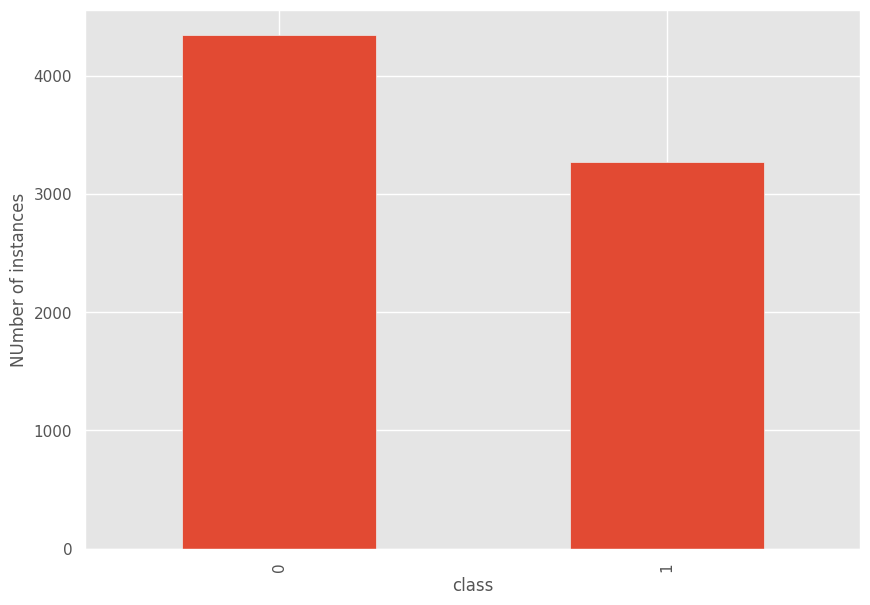

In [28]:
train_df['target'].value_counts().plot(kind='bar', figsize=(10,7))
plt.xlabel('class')
plt.ylabel('NUmber of instances')
plt.show()

## Number of characters in tweets

In [35]:
# check the number of characters in tweets for each row
tweet_len_c_0 = train_df[train_df['target']==0].text.str.len() 
tweet_len_c_1 = train_df[train_df['target']==1].text.str.len()

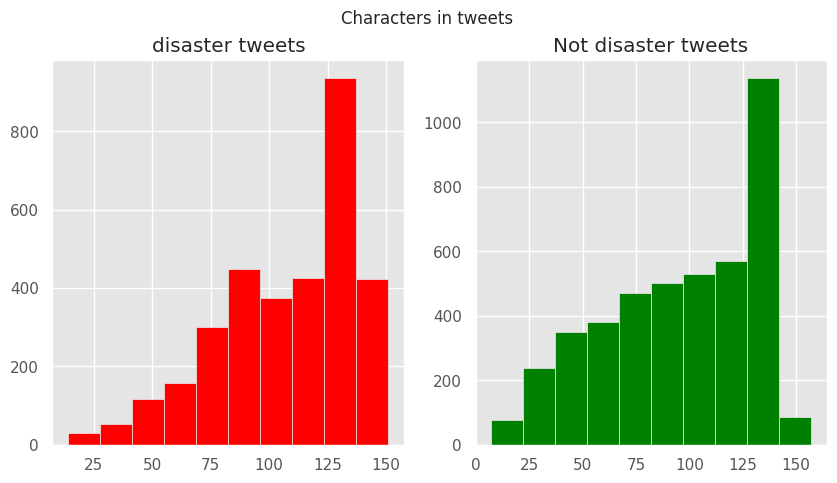

In [36]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(tweet_len_c_1, color='red')
ax1.set_title('disaster tweets')
ax2.hist(tweet_len_c_0, color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

## Number of words in a tweet

In [39]:
tweet_len_w_1=train_df[train_df['target']==1].text.str.split().map(lambda x: len(x))
tweet_len_w_0=train_df[train_df['target']==0].text.str.split().map(lambda x: len(x))

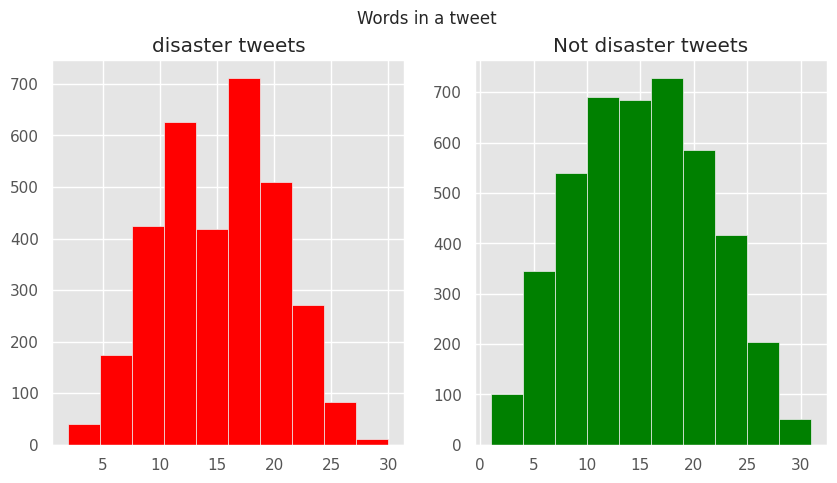

In [40]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(tweet_len_w_1,color='red')
ax1.set_title('disaster tweets')
ax2.hist(tweet_len_w_0,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

## Common stopwords in tweets

In [43]:
def create_corpus(target):
    corpus=[]
    
    for x in train_df[train_df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'the'),
  Text(1, 0, 'a'),
  Text(2, 0, 'to'),
  Text(3, 0, 'and'),
  Text(4, 0, 'of'),
  Text(5, 0, 'in'),
  Text(6, 0, 'you'),
  Text(7, 0, 'is'),
  Text(8, 0, 'for'),
  Text(9, 0, 'my'),
  Text(10, 0, 'on'),
  Text(11, 0, 'with'),
  Text(12, 0, 'that'),
  Text(13, 0, 'it'),
  Text(14, 0, 'be'),
  Text(15, 0, 'this'),
  Text(16, 0, 'by'),
  Text(17, 0, 'have'),
  Text(18, 0, 'at'),
  Text(19, 0, 'was')])

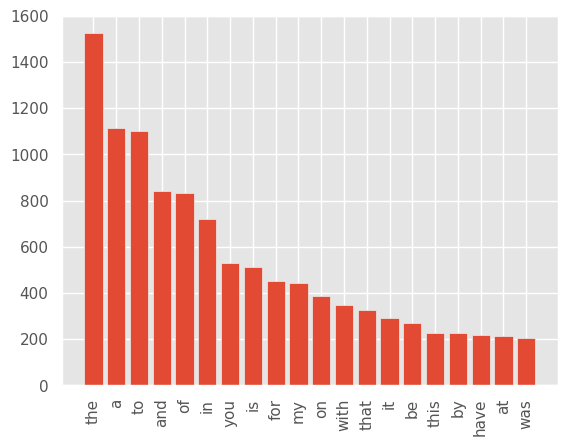

In [51]:
# the moset common stopwords in the not disaster tweet category
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20] 

x,y=zip(*top)
plt.bar(x,y)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'the'),
  Text(1, 0, 'in'),
  Text(2, 0, 'of'),
  Text(3, 0, 'a'),
  Text(4, 0, 'to'),
  Text(5, 0, 'and'),
  Text(6, 0, 'on'),
  Text(7, 0, 'for'),
  Text(8, 0, 'is'),
  Text(9, 0, 'at'),
  Text(10, 0, 'by'),
  Text(11, 0, 'from'),
  Text(12, 0, 'that'),
  Text(13, 0, 'with'),
  Text(14, 0, 'was'),
  Text(15, 0, 'are'),
  Text(16, 0, 'it'),
  Text(17, 0, 'after'),
  Text(18, 0, 'as'),
  Text(19, 0, 'have')])

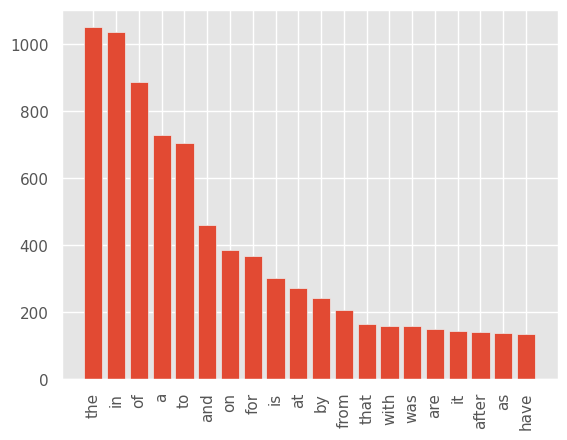

In [52]:
# the moset common stopwords in the disaster tweet category
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20] 
    


x,y=zip(*top)
plt.bar(x,y)
plt.xticks(rotation=90)

## Common words ?

In [ ]:
# counter=Counter(corpus)
# most=counter.most_common()
# x=[]
# y=[]
# for word,count in most[:40]:
#     if (word not in stop) :
#         x.append(word)
#         y.append(count)

# sns.barplot(x=y,y=x)

In [ ]:
# def get_top_tweet_bigrams(corpus, n=None):
#     vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
#     bag_of_words = vec.transform(corpus)
#     sum_words = bag_of_words.sum(axis=0) 
#     words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
#     words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#     return words_freq[:n]

In [ ]:
# plt.figure(figsize=(10,5))
# top_tweet_bigrams=get_top_tweet_bigrams(train_df['clean_text'])[:10]
# x,y=map(list,zip(*top_tweet_bigrams))
# sns.barplot(x=y,y=x)

In [ ]:
# # test dataframe
# test_df.head()

In [ ]:
# # 
# train_df.target.value_counts()

In [ ]:
# sample count
print(f'''total training samples: {len(train_df)},
total test samples: {len(test_df)},
total samples: {len(train_df)+len(test_df)}
''')

total training samples: 7613,
total test samples: 3263,
total samples: 10876



In [ ]:
# # import some necessaty libraries
# import re

# # creating a cleaning function
# def clean_text(data, column):
#     # remove username
#     data['clean_'+column] = data[column].apply(lambda x: re.sub(r'@\w+\b', '', x))

#     # remove 2 spaces
#     data['clean_'+column] = data['clean_'+column].apply(lambda x: re.sub('\s{2,}', ' ', x))

#     # remove weird characters
#     data['clean_'+column] = data['clean_'+column].apply(lambda x: ''.join(filter(lambda character: ord(character) < 128, x)))

#     # remove URL
#     data['clean_text'] = data['clean_'+column].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '')

In [ ]:
# clean_text(train_df, 'text')

In [ ]:
# import random
# random_text = random.randint(0, len(train_df))
# print(f"""text before cleaning: \n{train_df['text'][random_text]}
# text after cleaning: \n{train_df['clean_text'][random_text]}
# """)

In [ ]:
# train_df = train_df.drop_duplicates(subset=['clean_text'])

In [ ]:
# train_df['clean_text'] = train_df['text'].apply(lambda x: ''.join(filter(lambda character: ord(character) < 128, x)))

In [ ]:
# # visualizing some random samples
# random_idx = random.randint(0, len(train_df)-5)
# for row in train_df[['text', 'target']][random_idx:random_idx+5].itertuples():
#   _, text, target = row
#   print(f'Target: {target}', '(real disaster)' if target > 0 else "(not real disaster)")
#   print(f'Text: {text}\n')
#   print('---\n')

In [ ]:
# shuffle training df
train_df_sh = train_df.sample(frac=1, random_state=42)
train_df_sh.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


### Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df_sh['text'].to_numpy(),
                                                  train_df_sh['target'].to_numpy(),
                                                  test_size=0.1,
                                                  random_state=42)

In [ ]:
len(X_train), len(y_train), len(X_val),  len(y_val)

(6851, 6851, 762, 762)

In [ ]:
# View the first 10 training sentences and their labels
X_train[:10], y_train[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

Wonderful! We've got a training set and a validation set containing Tweets and labels.

Our labels are in numerical form (`0` and `1`) but our Tweets are in string form.

> 🤔 **Question:** What do you think we have to do before we can use a machine learning algorithm with our text data? 

If you answered something along the lines of "turn it into numbers", you're correct. A machine learning algorithm requires its inputs to be in numerical form.

In NLP, there are two main concepts for turning text into numbers:
* **Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
  1. Using **word-level tokenization** with the sentence "I love TensorFlow" might result in "I" being `0`, "love" being `1` and "TensorFlow" being `2`. In this case, every word in a sequence considered a single **token**.
  2. **Character-level tokenization**, such as converting the letters A-Z to values `1-26`. In this case, every character in a sequence considered a single **token**.
  3. **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple **tokens**.
* **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a **feature vector**. For example, the word "dance" could be represented by the 5-dimensional vector `[-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]`. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings: 
  1. **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)) and an embedding representation will be learned during model training.
  2. **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

### Text vectorization (tokenization)

Enough talking about tokenization and embeddings, let's create some.

We'll practice tokenzation (mapping our words to numbers) first.

To tokenize our words, we'll use the helpful preprocessing layer [`tf.keras.layers.experimental.preprocessing.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization).

The `TextVectorization` layer takes the following parameters:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens. 
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes, see docs for more.


In [ ]:
import tensorflow as tf
from keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", 
                                    ngrams=None, 
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) 
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [ ]:
# Find the AVG number of tokens
round(sum([len(i.split()) for i in X_train])/len(X_train))

15

In [ ]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 14 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

To map our `TextVectorization` instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.

In [ ]:
# fit the text_vectorizer to the training text
text_vectorizer.adapt(X_train)

In [ ]:
# Choose a random sentence from training dataset and tokenize it
random_sen = random.choice(X_train)
print(f'Original text: \n{random_sen}\n\nTokenized text:')
text_vectorizer([random_sen])

Original text: 
RT @startelegram: Homeless vulnerable during North Texas heat wave http://t.co/k9aIrFQ3QL http://t.co/JdBTlyMEhY

Tokenized text:


<tf.Tensor: shape=(1, 14), dtype=int64, numpy=
array([[  96, 8123, 2093, 2616,  246,  598,  758,  288,  472,    1,    1,
           0,    0,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all the unique words in training data
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"""Number of words in vocab: {len(words_in_vocab)}
5 most common words: {top_5_words}
5 least common words: {bottom_5_words}
""")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']



### Creating an Embedding using an Embedding Layer
We can see what an embedding of a word looks like by using the [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. 

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

In [ ]:
from keras.layers import Embedding

embedding = Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

In [ ]:
embedding

In [ ]:
# Get random sentence
random_sen = random.choice(X_train)
print(f"""Original text: {random_sen}
      embedded text:""")
# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sen]))
sample_embed

Original text: SSP East says a car AEG 061 driven by a young man collided with Akram's carhot words were exchanged n he did firing in air1bullet hit tyre
      embedded text:


<tf.Tensor: shape=(1, 14, 128), dtype=float32, numpy=
array([[[ 0.00741463, -0.0109704 , -0.01896334, ..., -0.04565113,
          0.03329584,  0.02860291],
        [ 0.00435829,  0.04554531,  0.03047231, ..., -0.00427973,
         -0.00386186,  0.04601412],
        [ 0.00790093, -0.03885766,  0.04294375, ..., -0.04058604,
         -0.04922701, -0.0070382 ],
        ...,
        [-0.01203829, -0.03703542, -0.0058944 , ...,  0.0416632 ,
          0.02068713,  0.01311293],
        [-0.02508645,  0.02397546, -0.04337856, ...,  0.00291855,
          0.04330095, -0.00778339],
        [ 0.04129777, -0.00513919,  0.03983979, ...,  0.04229678,
          0.04640552,  0.04332477]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sen

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.00741463, -0.0109704 , -0.01896334, -0.01392689,  0.04577636,
        -0.04508721,  0.02576159,  0.0421733 , -0.00786237,  0.01984418,
        -0.03187965, -0.04957538,  0.01369229,  0.03466965,  0.0425064 ,
        -0.02059093,  0.01857934,  0.03387249, -0.04736028, -0.02919652,
        -0.02619765, -0.03152361,  0.01054355,  0.0327381 , -0.03183892,
        -0.00945692, -0.00616336,  0.02265597,  0.01280414, -0.0418027 ,
         0.01001228, -0.03766292,  0.04616269,  0.04089547,  0.03694354,
         0.01351814, -0.02352386,  0.02442673,  0.02244909,  0.03067387,
         0.0429353 , -0.03868228, -0.02164167, -0.04788387,  0.02998752,
        -0.01822471, -0.03344964, -0.03264347,  0.04609941, -0.03817524,
         0.04125449,  0.01532007, -0.00537839, -0.01449819, -0.01870952,
         0.0447426 ,  0.02902016,  0.01789513,  0.01255221, -0.04998071,
        -0.01096519,  0.03468069,  0.01102027, -0.04781394,  0.04741199,
  

# Modelling a text dataset

*Once you've got your inputs and outputs prepared, it's a matter of figuring out which machine learning model to build in between them to bridge the gap.*

Now that we've got a way to turn our text data into numbers, we can start to build machine learning models to model it.

To get plenty of practice, we're going to build a series of different models, each as its own experiment. We'll then compare the results of each model and see which one performed best.

More specifically, we'll be building the following:
* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison


## Model 0: Getting a baseline

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the [Multinomial Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). This was chosen via referring to the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("cls", MultinomialNB())
])

# fit the pipeline to the training data
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('cls', MultinomialNB())])

In [ ]:
base_score = model_0.score(X_val, y_val)
print(f"Our baseline model achieves an accuracy of: {base_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# make predictions
base_preds = model_0.predict(X_val)
base_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model `accuracy`, `precision`, `recall` and `f1 score` of a binary classification model.

  Args:
  -----
  `y_true` = true labels in the form of a 1D array
  `y_pred` = predicted labels in the form of a 1D array
  ---

  Returns:
  ----- 
    dictionary of accuracy, precision, recall, f1-score.

  ---

  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
base_results = calculate_results(y_val, base_preds)

## Model 1: Feed-forward neural network (dense model)

The first "deep" model we're going to build is a single layer dense model. In fact, it's barely going to have a single layer. 

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

If the previous sentence sounds like a mouthful, it'll make sense when we code it out (remember, if in doubt, code it out).

In [ ]:
# Build model with the functional API
from keras import Model, Input
from keras.layers import GlobalAveragePooling1D, Dense
from keras.optimizers import Adam

inputs = Input(shape=(1,),dtype='string', name="input_layer")
x = text_vectorizer(inputs)
x = embedding(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(1, "sigmoid", name="output_layer")(x)

model_1 = Model(inputs, outputs)

In [ ]:
# compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 14, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [ ]:
model_1_history = model_1.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val))

Epoch 1/5
215/215 [==============================] - 2s 5ms/step - loss: 0.6097 - accuracy: 0.6882 - val_loss: 0.5344 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4400 - accuracy: 0.8210 - val_loss: 0.4750 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3458 - accuracy: 0.8618 - val_loss: 0.4665 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2826 - accuracy: 0.8920 - val_loss: 0.4750 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2364 - accuracy: 0.9143 - val_loss: 0.4895 - val_accuracy: 0.7808


In [ ]:
# evaluate the model
model_1.evaluate(X_val, y_val)

24/24 [==============================] - 0s 3ms/step - loss: 0.4895 - accuracy: 0.7808


[0.48949766159057617, 0.7808399200439453]

In [ ]:
# make predictions
model_1_pred_probs = model_1.predict(X_val)

24/24 [==============================] - 0s 2ms/step


In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
# calculate some metrics
model_1_results = calculate_results(y_val, model_1_preds)
model_1_results

{'accuracy': 78.08398950131233,
 'precision': 0.7828610537338687,
 'recall': 0.7808398950131233,
 'f1': 0.7787902197895524}

In [ ]:
# Create a function to compare our base results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [ ]:
compare_baseline_to_new_results(base_results, 
                                model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.08, Difference: -1.18
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


## Recurrent Neural Networks (RNN's)

## Model 2: Long short-term memory cells (**LSTMs**) model
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [ ]:
from keras.layers import LSTM
tf.random.set_seed(42)

inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = LSTM(units=64, return_sequences=True)(x)
print(x.shape)
x = LSTM(64)(x) # return vector for whole sequence
print(x.shape)
x = Dense(64, 'relu')(x)
outputs = Dense(1, 'sigmoid')(x)

model_2 = Model(inputs, outputs)

(None, 14, 128)
(None, 14, 64)
(None, 64)


In [ ]:
model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 14, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 14, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                           

In [ ]:
model_2_history = model_2.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val))

Epoch 1/5
215/215 [==============================] - 7s 11ms/step - loss: 0.2295 - accuracy: 0.9207 - val_loss: 0.5550 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1655 - accuracy: 0.9404 - val_loss: 0.6138 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1320 - accuracy: 0.9518 - val_loss: 0.7657 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1114 - accuracy: 0.9584 - val_loss: 0.8772 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0853 - accuracy: 0.9644 - val_loss: 0.9535 - val_accuracy: 0.7612


In [ ]:
# make predictions with LSTM model
model_2_pred_probs = model_2.predict(X_val)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[1.3933334e-02],
       [5.5723542e-01],
       [9.9987900e-01],
       [9.8284066e-02],
       [5.5396878e-05],
       [9.9388349e-01],
       [9.6740460e-01],
       [9.9970120e-01],
       [9.9975175e-01],
       [2.0735130e-02]], dtype=float32)

In [ ]:
# convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# calculate the results
model_2_results = calculate_results(y_val,
                                    model_2_preds)
model_2_results

{'accuracy': 76.11548556430446,
 'precision': 0.7645775884027154,
 'recall': 0.7611548556430446,
 'f1': 0.7579576679636106}

In [ ]:
# comparing the results
compare_baseline_to_new_results(base_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 76.12, Difference: -3.15
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


## Model 3: Gated Recurrent Unit (**GRU**)
📓 To solve the vanishing gradient problem of a standard **RNN**, **GRU** uses, so-called, `update gate and reset gate`. Basically, these are two vectors which decide what information should be passed to the output. 

The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.

In [ ]:
from keras.layers import GRU

inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = GRU(64, return_sequences=True)(x)
x = GRU(64)(x)
x = Dense(64, 'relu')(x)
outputs = Dense(1, 'sigmoid')(x)

model_3 = Model(inputs, outputs)

In [ ]:
model_3.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 14, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 14, 64)            37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                           

In [ ]:
model_3_history = model_3.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val))

Epoch 1/5
215/215 [==============================] - 55s 13ms/step - loss: 0.1477 - accuracy: 0.9507 - val_loss: 0.6968 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0907 - accuracy: 0.9680 - val_loss: 0.7981 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0691 - accuracy: 0.9724 - val_loss: 1.3507 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0620 - accuracy: 0.9737 - val_loss: 1.3192 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0527 - accuracy: 0.9755 - val_loss: 1.2508 - val_accuracy: 0.7651


In [ ]:
model_3_prob_preds = model_3.predict(X_val)
model_3_prob_preds[:10]

24/24 [==============================] - 1s 3ms/step


array([[2.4282476e-03],
       [5.7455033e-01],
       [9.9995935e-01],
       [8.0470987e-02],
       [3.2743865e-05],
       [9.9985027e-01],
       [9.9871755e-01],
       [9.9997413e-01],
       [9.9996948e-01],
       [5.3134779e-03]], dtype=float32)

In [ ]:
# convert prediction probs to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_prob_preds))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calcuate model_3 results
model_3_results = calculate_results(y_val,
                                    model_3_preds)
model_3_results

{'accuracy': 76.50918635170603,
 'precision': 0.7669456967235844,
 'recall': 0.7650918635170604,
 'f1': 0.7627590065822708}

In [ ]:
# compare the results with the base model results
compare_baseline_to_new_results(base_results,
                                model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.51, Difference: -2.76
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


```
Still can't beat the base model accuracy
```



## Model 4: Bidirectonal LSTM model

In [ ]:
from keras.layers import Bidirectional

inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(64))(x)
x = Dense(64, 'relu')(x)
outputs = Dense(1, 'sigmoid')(x)

model_4 = Model(inputs, outputs)

In [ ]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 14, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 14, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                           

In [ ]:
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
# fit the model 4
model_4_history = model_4.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val))

Epoch 1/5
215/215 [==============================] - 10s 17ms/step - loss: 0.0948 - accuracy: 0.9685 - val_loss: 1.1379 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0510 - accuracy: 0.9758 - val_loss: 1.4787 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0443 - accuracy: 0.9781 - val_loss: 1.6726 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0445 - accuracy: 0.9791 - val_loss: 1.6699 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0416 - accuracy: 0.9791 - val_loss: 1.6413 - val_accuracy: 0.7638


In [ ]:
model_4_prob_preds = model_4.predict(X_val)

24/24 [==============================] - 2s 4ms/step


In [ ]:
model_4_preds = tf.squeeze(tf.round(model_4_prob_preds))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# calculate the results
model_4_results = calculate_results(y_val,
                                    model_4_preds)

In [ ]:
# comparing results
compare_baseline_to_new_results(base_results,
                                model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.38, Difference: -2.89
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


```
Still not enough
```

### Model 5: 1D Convolutional Neural Network

In [ ]:
from keras.layers import Conv1D, GlobalMaxPool1D

inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = Conv1D(32, 5, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, 'relu')(x)
outputs = Dense(1, 'sigmoid')(x)

model_5 = Model(inputs, outputs)

In [ ]:
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 14, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 10, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_6 (Dense)             (None, 64)                2112

In [ ]:
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
model_5_history = model_5.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val))

Epoch 1/5
215/215 [==============================] - 7s 7ms/step - loss: 0.1404 - accuracy: 0.9539 - val_loss: 0.8589 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0747 - accuracy: 0.9717 - val_loss: 1.0566 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0536 - accuracy: 0.9771 - val_loss: 1.1559 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0432 - accuracy: 0.9793 - val_loss: 1.2570 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0371 - accuracy: 0.9812 - val_loss: 1.4694 - val_accuracy: 0.7559


In [ ]:
model_5_prob_preds = model_5.predict(X_val)

24/24 [==============================] - 0s 2ms/step


In [ ]:
model_5_preds = tf.squeeze(tf.round(model_5_prob_preds))

In [ ]:
model_5_results = calculate_results(y_val,
                                    model_5_preds)

In [ ]:
compare_baseline_to_new_results(base_results,
                                model_5_results)

Baseline accuracy: 79.27, New accuracy: 75.59, Difference: -3.67
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.03


```
it's worse than Model 5
```

### Model 6: TensorFlow Hub Pretrained universal-sentence-encoder (USE)

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_smpl = embed([random_sen,
                    "wWhen you call the USE on a sentence, it turns it into numbers"])

print(embed_smpl[0][:50])

tf.Tensor(
[-0.0396533   0.06021218 -0.02325723  0.00425004 -0.00441336  0.01414473
  0.06195759 -0.01171541  0.06773853  0.03433008  0.00340804 -0.03785937
 -0.05054251  0.04185335  0.04215835 -0.03270803  0.03778789 -0.0095736
  0.06073208  0.00059673 -0.06404386  0.03406754  0.01051561  0.02910565
  0.06552637  0.05171186 -0.00031572 -0.0061042  -0.07401308 -0.05804861
  0.00524113 -0.02784795  0.04382947 -0.05622896 -0.06495622  0.01283607
  0.00053981  0.02726025  0.03762861  0.02139096 -0.01300111  0.04781037
  0.02261963  0.0267237  -0.0865939   0.04815752  0.01325967  0.01940236
  0.0014044   0.07880729], shape=(50,), dtype=float32)


In [ ]:
embed_smpl

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.0396533 ,  0.06021218, -0.02325723, ..., -0.02664887,
        -0.06647705, -0.02938745],
       [-0.00052549, -0.08578814,  0.02460889, ..., -0.03588752,
         0.00757878, -0.00431355]], dtype=float32)>

In [ ]:
# create keraslayer
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [ ]:
# Create the model (Sequential API)
from keras import Sequential

model_6 = Sequential([
    sentence_encoder_layer, # take in sentences and then encode them into an embedding
    Dense(64, 'relu'),
    Dense(1, 'sigmoid')
], name='model_6_USE')

model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_6_history = model_6.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val))

Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.5058 - accuracy: 0.7860 - val_loss: 0.4495 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4155 - accuracy: 0.8136 - val_loss: 0.4380 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4007 - accuracy: 0.8208 - val_loss: 0.4336 - val_accuracy: 0.8084
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3936 - accuracy: 0.8257 - val_loss: 0.4292 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3877 - accuracy: 0.8283 - val_loss: 0.4310 - val_accuracy: 0.8150


In [ ]:
model_6_preds = tf.squeeze(tf.round(model_6.predict(X_val)))
model_6_preds[:10]

24/24 [==============================] - 1s 9ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_6_results = calculate_results(y_val,
                                    model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8179063565195398,
 'recall': 0.8149606299212598,
 'f1': 0.8132300658103407}

In [ ]:
compare_baseline_to_new_results(base_results,
                                model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.50, Difference: 2.23
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03



```
it looks like we improve thy accuracy a little bit
```



### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [ ]:
# get only 10 percent of the dataset
train_10_percent = train_df_sh[['text','target']].sample(frac=0.1, random_state=42)
X_train_10_percent = train_10_percent['text'].to_list()
y_train_10_percent = train_10_percent['target'].to_list()

In [ ]:
# see how much we have in the 10% dataset
train_10_percent['target'].value_counts(), train_df_sh['target'].value_counts()

(0    413
 1    348
 Name: target, dtype: int64,
 0    4342
 1    3271
 Name: target, dtype: int64)

> to recreate the same model as model 6 we can use `tf.keras.models.clone_model()`

In [ ]:
# building the model 7
model_7 = Sequential([
    sentence_encoder_layer,
    Dense(64, 'relu'),
    Dense(1, 'sigmoid')
], name='model_7_USE')

model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_7_history = model_7.fit(X_train_10_percent,
                              y_train_10_percent,
                              epochs=5,
                              validation_data=(X_val, y_val))

Epoch 1/5
24/24 [==============================] - 2s 60ms/step - loss: 0.6690 - accuracy: 0.6675 - val_loss: 0.6276 - val_accuracy: 0.7835
Epoch 2/5
24/24 [==============================] - 1s 37ms/step - loss: 0.5908 - accuracy: 0.7792 - val_loss: 0.5442 - val_accuracy: 0.7861
Epoch 3/5
24/24 [==============================] - 1s 25ms/step - loss: 0.5128 - accuracy: 0.7924 - val_loss: 0.4769 - val_accuracy: 0.8045
Epoch 4/5
24/24 [==============================] - 1s 25ms/step - loss: 0.4578 - accuracy: 0.8055 - val_loss: 0.4332 - val_accuracy: 0.8150
Epoch 5/5
24/24 [==============================] - 1s 23ms/step - loss: 0.4222 - accuracy: 0.8200 - val_loss: 0.4035 - val_accuracy: 0.8241


In [ ]:
model_7_preds =tf.squeeze(tf.round(model_7.predict(X_val)))

24/24 [==============================] - 1s 9ms/step


In [ ]:
# calculate the results
model_7_results = calculate_results(y_val,
                                    model_7_preds)

In [ ]:
# Compare'm with the base model
compare_baseline_to_new_results(base_results,
                                model_7_results)

Baseline accuracy: 79.27, New accuracy: 82.41, Difference: 3.15
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.03
Baseline f1: 0.79, New f1: 0.82, Difference: 0.04


we can see that it perform better than the model 6, but it's only because we had a data leakage.

**the data from the validation it got leaked into the train data**

to solve it we need to split the data correctly
```
X_10_percent = int(0.1*len(X_train))
y_10_percent = int(0.1*len(y_train))

X_train_10_percent = X_train[:X_10_percent]
y_train_10_percent = y_train[:y_10_percent]
```

### Model 8: same as model 7 but without data leakage

In [ ]:
X_10_percent = int(0.1*len(X_train))
y_10_percent = int(0.1*len(y_train))

X_train_10_percent = X_train[:X_10_percent]
y_train_10_percent = y_train[:y_10_percent]

In [ ]:
model_8 = tf.keras.models.clone_model(model_7)
model_8.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])
model_8.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_8_history = model_8.fit(X_train_10_percent,
                              y_train_10_percent,
                              epochs=5,
                              validation_data=(X_val, y_val))

Epoch 1/5
22/22 [==============================] - 4s 81ms/step - loss: 0.6600 - accuracy: 0.7358 - val_loss: 0.6350 - val_accuracy: 0.7559
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5838 - accuracy: 0.8146 - val_loss: 0.5769 - val_accuracy: 0.7664
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5092 - accuracy: 0.8161 - val_loss: 0.5276 - val_accuracy: 0.7756
Epoch 4/5
22/22 [==============================] - 0s 23ms/step - loss: 0.4526 - accuracy: 0.8219 - val_loss: 0.5015 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4139 - accuracy: 0.8336 - val_loss: 0.4874 - val_accuracy: 0.7769


In [ ]:
model_8_preds = tf.squeeze(tf.round(model_8.predict(X_val)))

24/24 [==============================] - 1s 9ms/step


In [ ]:
model_8_results = calculate_results(y_val,
                                    model_8_preds)

In [ ]:
compare_baseline_to_new_results(base_results,
                                model_8_results)

Baseline accuracy: 79.27, New accuracy: 77.69, Difference: -1.57
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


### Model 9: The Big Boy model (Attention is all you need)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.9 MB/s eta 0:00:00


In [ ]:
# Tokenizer and Model
from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
bert = TFAutoModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
print(f'''Original: {train_df.text[0]}
      Tokenized: {tokenizer.tokenize(train_df.text[0])}
      Token id: {tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_df.text[0]))}
''')

Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
      Tokenized: ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
      Token id: [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]



In [ ]:
max_len = 0

# For every sentence...
for text in train_df.text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [ ]:
# Making list of sentence lenghts:

token_lens = []
for text in train_df.text:
    tokens = tokenizer.encode(text, max_length = 512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<ipython-input-172-8a7d3bb1221e>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens, color='#e74c3c')


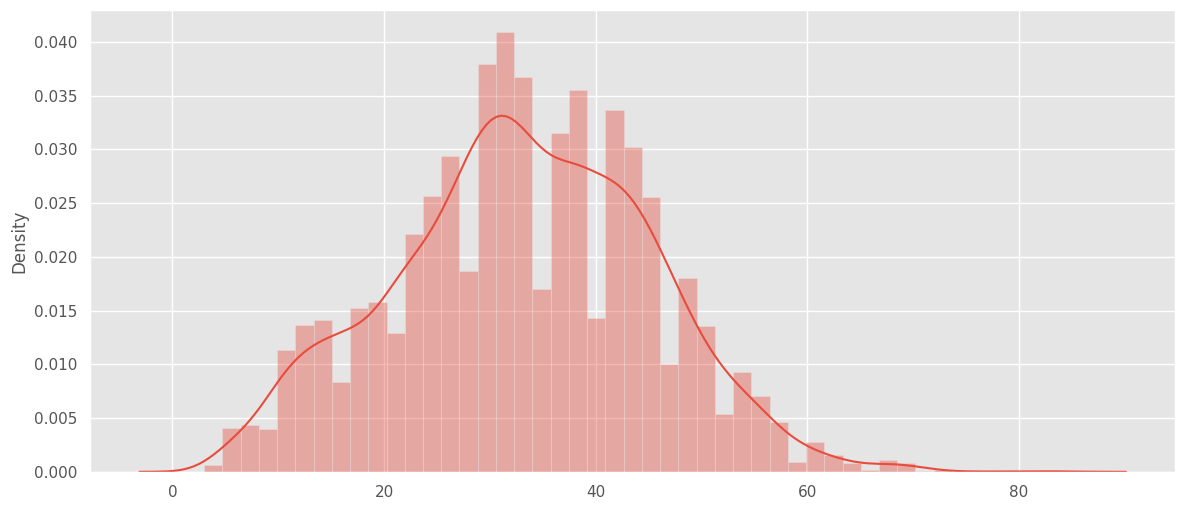

In [ ]:
# Displaying sentence length dist.

fig, axes = plt.subplots(figsize=(14, 6))
sns.distplot(token_lens, color='#e74c3c')
plt.show()

In [ ]:
labels = train_df['target'].values
idx = len(labels)

train= train_df.text[:idx]
val = train_df.text[idx:]
train.shape, val.shape

((7613,), (0,))

In [ ]:
def tokenize_map(sentence, labs=None):
    """A function to tokenize all the sentences and map the tokens to their word IDs."""

    global labels

    input_ids = []
    attention_masks = []

    # For every sentence...
    for text in sentence:
        #   "encode" will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.

        encoded_dict = tokenizer.encode_plus(
            text,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            truncation='longest_first',  # Activate and control truncation
            max_length=84,  # Max length according to our text data.
            padding='max_length',  # Pad & truncate all sentences.
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='tf',  # Return TensorFlow tensors.
        )

        # Add the encoded sentence to the id list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)

    if labs is not None:
        # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = tf.constant(labs, dtype=tf.int32)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks


In [ ]:
# Tokenizing all of the train test sentences and mapping the tokens to their word IDs.
import tensorflow as tf
input_ids, attention_masks, labels = tokenize_map(train, labels)

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, labels))

# restructure dataset format for BERT
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels
  
dataset = dataset.map(map_func)  # apply the mapping function

# shuffle and batch the dataset
dataset = dataset.shuffle(10000).batch(32)

DS_LEN = len(list(dataset))  # get dataset length

SPLIT = 0.9  # we will create a 90-10 split

# create training-validation sets
train = dataset.take(round(DS_LEN*SPLIT))
val = dataset.skip(round(DS_LEN*SPLIT))

In [ ]:
# Get all of the model's trainable variables as a list of tuples
params = list(bert.trainable_variables)

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p.name, str(tuple(p.shape))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p.name, str(tuple(p.shape))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p.name, str(tuple(p.shape))))


The BERT model has 391 different named parameters.

==== Embedding Layer ====

tf_bert_model/bert/embeddings/word_embeddings/weight:0  (30522, 1024)
tf_bert_model/bert/embeddings/token_type_embeddings/embeddings:0    (2, 1024)
tf_bert_model/bert/embeddings/position_embeddings/embeddings:0  (512, 1024)
tf_bert_model/bert/embeddings/LayerNorm/gamma:0              (1024,)
tf_bert_model/bert/embeddings/LayerNorm/beta:0               (1024,)

==== First Transformer ====

tf_bert_model/bert/encoder/layer_._0/attention/self/query/kernel:0 (1024, 1024)
tf_bert_model/bert/encoder/layer_._0/attention/self/query/bias:0      (1024,)
tf_bert_model/bert/encoder/layer_._0/attention/self/key/kernel:0 (1024, 1024)
tf_bert_model/bert/encoder/layer_._0/attention/self/key/bias:0      (1024,)
tf_bert_model/bert/encoder/layer_._0/attention/self/value/kernel:0 (1024, 1024)
tf_bert_model/bert/encoder/layer_._0/attention/self/value/bias:0      (1024,)
tf_bert_model/bert/encoder/layer_._0/attention/output/dense

In [ ]:
# Encoding Inputs
SEQ_LEN = 15

tokenizer.encode_plus("sentence", max_length=SEQ_LEN, truncation=True,
                      pad_to_max_length=True, add_special_tokens=True,
                      return_attention_mask=True, return_token_type_ids=False,
                      return_tensors='tf')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=
array([[ 101, 6251,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [ ]:
# build the model
import tensorflow as tf

input_ids = tf.keras.layers.Input(shape=(84,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(84,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]  # we only keep tensor 0 (last_hidden_state)

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)  # reduce tensor dimensionality
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(X)  # 3 labels due to three sentiment classes

model_9 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze the DistilBERT layer
model_9.layers[2].trainable = False

In [ ]:
model_9.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model_9.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 84)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 84)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 84,                                          

In [ ]:
model_9_history = model_9.fit(train, epochs=2)

Epoch 1/2
214/214 [==============================] - 165s 587ms/step - loss: 0.5409 - accuracy: 0.7583
Epoch 2/2
214/214 [==============================] - 128s 597ms/step - loss: 0.4573 - accuracy: 0.7925


In [ ]:
model_9.predict(val)

24/24 [==============================] - 19s 563ms/step


array([[6.77577496e-01],
       [3.40938754e-02],
       [1.06845230e-01],
       [8.63962293e-01],
       [4.78444248e-01],
       [9.60955679e-01],
       [9.25952375e-01],
       [1.60293177e-01],
       [9.93414640e-01],
       [9.93329287e-01],
       [9.96406257e-01],
       [1.87183365e-01],
       [8.55215073e-01],
       [1.41676098e-01],
       [9.46618438e-01],
       [1.21620350e-01],
       [2.95701057e-01],
       [1.46021739e-01],
       [1.60993591e-01],
       [9.77736488e-02],
       [9.07536075e-02],
       [6.19388342e-01],
       [5.47733568e-02],
       [1.57937571e-01],
       [1.10296801e-01],
       [9.60517645e-01],
       [4.44792733e-02],
       [9.78589356e-01],
       [1.49794325e-01],
       [8.45127478e-02],
       [2.99374247e-03],
       [1.99228495e-01],
       [2.12285984e-02],
       [2.27248192e-01],
       [9.96366143e-01],
       [2.76497871e-01],
       [8.30610156e-01],
       [8.23727787e-01],
       [7.86767125e-01],
       [9.03533548e-02],


In [ ]:
model_9_results = model_9.evaluate(val)

24/24 [==============================] - 20s 566ms/step - loss: 0.3694 - accuracy: 0.8392


In [ ]:
def flat_accuracy(preds, labels):
    
    """A function for calculating accuracy scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    
    """A function for calculating f1 scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, pred_flat)

In [ ]:
def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Some Analysis

## Comparing the performance of each of our models

In [ ]:
all_model_results = pd.DataFrame({'baseline':base_results,
                                   'simple dense':model_1_results,
                                   'LSTM':model_2_results,
                                   'GRU':model_3_results,
                                   'Bidirectional':model_4_results,
                                   '1D CNN':model_5_results,
                                   'USE':model_6_results,
                                   'USE 10% with leakage':model_7_results,
                                   'USE 10% without leakage':model_8_results})
all_model_results = all_model_results.transpose()

In [ ]:
all_model_results

In [ ]:
# scale the accuracy to match the other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
# plot the results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10,7))

ignoring the model with the data leakage, we can see that USE TensorFlow Hub models performing better than all of the other models

## saving, load and evaluate the model 6

In [ ]:
# saving the model
model_6.save('model.h5')

In [ ]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model = tf.keras.models.load_model('model.h5', custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# evaluate the model
loaded_model.evaluate(X_val, y_val)

## Finding the most wrong examples